In [1]:
# Initialise
%run ~/relmapping/annot/notebooks/__init__.ipynb

/mnt/home3/jj374/anaconda36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


os.getcwd(): /mnt/beegfs/scratch_copy/ahringer/jj374/lab/relmapping


In [108]:
# Load new annotation & test known corner cases
fp_regl = 'annot/S2_regulatory_annotation/S2_regulatory_annotation.tsv'
df_regl = pd.read_csv(fp_regl, sep='\t')
print('%d regions loaded' % (len(df_regl),))

def check_(igvstr, **kwargs):
    (chrom, start, end) = yp.parse_igvstr(igvstr)
    pos = int((start + end) / 2)
    df_ = df_regl.query('(chrom == "%s") & (start <= %d) & (%d < end)' % (chrom, pos, pos))
    assert len(df_) == 1
    for (k, v) in kwargs.items():
        print('\t'.join([igvstr, '%25s' % (k,), '%25s' % (v,), '%25s' % (df_[k].tolist()[0],)]))
        assert df_[k].tolist()[0] == v

#> rfc-4 (black element - promoter inside masked??)
#> zen-4 (black element - should be promoter?)sonRNA, I guess could mask promoter
#Rare but compelling cases of bidirectional promoters where one direction was protein-coding, and the other was an annotated non-coding RNA. Addressed by relaxing the non-coding RNA annotation. They're now treated more similarly to protein-coding annotations, so a site can be annotated as protein_coding on one strand, and snoRNA on the other strand. (Previously, any site that overlapped a non-coding RNA was excluded from any other annotation...)
#> attf-2 (black element maybe promoter?)
#Now annotated as a promoter for F09G2.2 (protein-coding gene, forward strabd), and F09G2.14 (snoRNA, reverse strand). Could also be a promoter for attf-2, but can't think of much one could do about this give current fragmented long cap data.
check_('chrIV:6117863-6118043',
       annot_fwd='coding_promoter', promoter_locus_id_fwd='zen-4',
       annot_rev='non-coding_RNA', promoter_locus_id_rev='M03D4.78')

## "Dual" coding/non-coding annotations: coding_promoter >> non-coding_RNA
check_('chrIII:6971981-6972101', 
       annot_fwd='coding_promoter', promoter_locus_id_fwd='rfc-4',
       annot_rev='coding_promoter', promoter_locus_id_rev='eef-1A.1') # alternative: mir-5549
check_('chrV:7196589-7196718',
       annot_fwd='coding_promoter', promoter_locus_id_fwd='F09G2.2',
       annot_rev='coding_promoter', promoter_locus_id_rev='attf-2') # alternative: F09G2.14

check_('chrII:13596635-13596738', annot_rev='coding_promoter', promoter_locus_id_rev='fbxc-23')

#> fbxc-15
#Fixed by tweaking the long cap jump test.
check_('chrII:979338-979455', annot_fwd='coding_promoter', promoter_locus_id_fwd='fbxc-15')

#> sri-5 (promoter annotated to rsr-1 only)
#> C25F9.6 (promoter annotate to C25F9.6 only) - looks like there is jump in txn?
#> F08F3.8 (promoter annotated to acl-6 only) - looks like there is longcap signal
#> rsd-2 (maybe one of the yellow elements promoter?) Looks like there is txn from furthest right yellow element
#Weak outron signal; now captured by requiring 1 long cap tag in each replicate, and at least 3 tags total (previously at least 2 tags in both replicates).
check_('chrI:11182502-11182624', annot_rev='coding_promoter', promoter_locus_id_rev='rsr-1')
check_('chrV:19405507-19405707', 
       annot_fwd='coding_promoter', promoter_locus_id_fwd='C25F9.10',
       annot_rev='coding_promoter', promoter_locus_id_rev='C25F9.6')
check_('chrV:5433170-5433353', annot_fwd='coding_promoter', promoter_locus_id_fwd='acl-6')

check_('chrIV:13541820-13541934', annot_rev='coding_promoter', promoter_locus_id_rev='rsd-2')

# Sites downstream within a long exon that should not be called promoters
check_('chrII:7150014-7150236', annot_fwd='no_transcription', annot_rev='transcription_initiation')
check_('chrI:183422-183568', annot_fwd='transcription_initiation', associated_locus_id='atm-1')

# "Long distance" ncRNA annotations (should not happen)
check_('chrII:6891890-6892040', annot_fwd='coding_promoter', annot_rev='coding_promoter')

# addressed via closest_exon_flank ~< 250 (ncRNA downstream of site; exon1 from upstream gets mis-assigned)
check_('chrI:111191-111378', annot_fwd='non-coding_RNA', promoter_locus_id_fwd='F53G12.12')

# Non-coding RNAs within outrons should not 'block' upstream promoter annotation
check_('chrI:13324560-13324714', annot_fwd='coding_promoter', promoter_locus_id_fwd='gcy-35') # Reverse strand shows weak-gapped-but-compelling long cap?
check_('chrI:13372998-13373215', annot_rev='coding_promoter', promoter_locus_id_rev='sptf-3')
check_('chrIII:6971981-6972101', annot_fwd='coding_promoter', promoter_locus_id_fwd='rfc-4')
check_('chrIII:6971981-6972101', annot_rev='coding_promoter', promoter_locus_id_rev='eef-1A.1')
check_('chrI:13372998-13373215', annot_rev='coding_promoter', promoter_locus_id_rev='sptf-3')

# Long cap jump -- weak regions
check_('chrI:14316482-14316632', annot_fwd='pseudogene_promoter', promoter_locus_id_fwd='F49B2.4') # Also, reverse strand shows weak-gapped-but-compelling long cap (however no short cap!)?

# Short cap 100..125bp from peak accessibility...
#check_('chrI:6341909-6342059', annot_rev='unknown_promoter')
check_('chrII:14468955-14469118', annot_fwd='unknown_promoter')
# Short cap >125bp from peak accessibility...
#check_('chrII:14468955-14469118', annot_rev='unknown_promoter')

# Promoters initiating transcription within the UTR, downstream of the annotated TSS
check_('chrI:6011491-6011614', annot_rev='coding_promoter', promoter_locus_id_rev='rnf-1')
check_('chrI:7643236-7643386', annot_rev='coding_promoter', promoter_locus_id_rev='ncbp-2')
check_('chrII:2320231-2320381', annot_fwd='coding_promoter', promoter_locus_id_fwd='ZK1240.3')
check_('chrII:6775038-6775173', annot_rev='coding_promoter', promoter_locus_id_rev='agr-1')
check_('chrII:2296175-2296310', annot_rev='coding_promoter', promoter_locus_id_rev='fbxc-25')

# Various weak-ish/corner cases where a clear unique promoter candidate exists
check_('chrI:5509301-5509451', annot_rev='coding_promoter', promoter_locus_id_rev='zipt-11') # upstream long cap overlaps upstream gene 3' end
check_('chrII:2772185-2772335', annot_rev='coding_promoter', promoter_locus_id_rev='sdz-10')
check_('chrV:5433187-5433337', annot_rev='coding_promoter', promoter_locus_id_rev='F08F3.8') # distal; site has no long cap (but has continuous txn)
check_('chrII:1818315-1818462', annot_rev='coding_promoter', promoter_locus_id_rev='fbxb-10') # short cap mode within first exon
check_('chrI:11182502-11182624', annot_fwd='coding_promoter', promoter_locus_id_fwd='sri-5') # no short cap
check_('chrI:11182502-11182624', annot_rev='coding_promoter', promoter_locus_id_rev='rsr-1')
check_('chrV:5433170-5433353', annot_rev='coding_promoter', promoter_locus_id_rev='F08F3.8') # no short cap
check_('chrI:13376619-13376731', annot_fwd='coding_promoter', promoter_locus_id_fwd='C01A2.9') # should be detected in d13_fwd -- padj 0.32, missed
check_('chrII:1818315-1818462', annot_rev='coding_promoter', promoter_locus_id_rev='fbxb-10') # short cap within 1st exon
check_('chrII:1818315-1818462', annot_fwd='unknown_promoter') # weak unknown_promoter on fwd strand
check_('chrII:14563893-14564084', annot_rev='pseudogene_promoter', promoter_locus_id_rev='C01G12.12') # pseudogene promoters without short cap!
check_('chrX:14706659-14706809', annot_rev='transcription_initiation') # should not be an unknown_promoter, as is proximal to first exon
check_('chrII:13596635-13596738', annot_fwd='coding_promoter', promoter_locus_id_fwd='csc-1') # "distal"; no scap
check_('chrIII:1163615-1163765', annot_fwd='no_transcription', annot_rev='no_transcription') # Should not be a promoter of Y119D3B.13

# afd-1 locus -- two sites with long cap gaps, should not be called promoters (but not necessarily unknown_promoter either)
check_('chrI:2167906-2168056', annot_fwd='unknown_promoter')
check_('chrI:2179963-2180113', annot_fwd='unknown_promoter')

# Y37E3.11 locus -- too far from the annotated TSS to be associated with that UTR
check_('chrI:2084937-2085087', annot_fwd='non-coding_RNA', promoter_locus_id_fwd='Y37E3.20')

# Weak promoter with several non-first alternative isoforms overlapping the first exon
check_('chrI:2084303-2084453', annot_fwd='coding_promoter', promoter_locus_id_fwd='Y37E3.11')

check_('chrI:5485932-5486082', annot_rev='coding_promoter', promoter_locus_id_rev='rpl-19')
check_('chrI:5485932-5486082', annot_fwd='unknown_promoter')

42245 regions loaded
chrIV:6117863-6118043	                annot_fwd	          coding_promoter	          coding_promoter
chrIV:6117863-6118043	    promoter_locus_id_fwd	                    zen-4	                    zen-4
chrIV:6117863-6118043	                annot_rev	           non-coding_RNA	           non-coding_RNA
chrIV:6117863-6118043	    promoter_locus_id_rev	                 M03D4.78	                 M03D4.78
chrIII:6971981-6972101	                annot_fwd	          coding_promoter	          coding_promoter
chrIII:6971981-6972101	    promoter_locus_id_fwd	                    rfc-4	                    rfc-4
chrIII:6971981-6972101	                annot_rev	          coding_promoter	          coding_promoter
chrIII:6971981-6972101	    promoter_locus_id_rev	                 eef-1A.1	                 eef-1A.1
chrV:7196589-7196718	                annot_fwd	          coding_promoter	          coding_promoter
chrV:7196589-7196718	    promoter_locus_id_fwd	                  F09G2.2	   

In [ ]:
# Differences to previous github version
#fp_head_bed = 'annot/S2_regulatory_annotation/S2_regulatory_annotation.bed_HEAD.bed'
#fp_head_tsv = 'annot/S2_regulatory_annotation/S2_regulatory_annotation.tsv_HEAD.tsv'
#!git show HEAD:{fp_regl} > {fp_head_tsv}
#!git show HEAD:annot/S2_regulatory_annotation/S2_regulatory_annotation.bed > {fp_head_bed}

# Diff against a specific earlier version
#fp_head_bed = 'annot/S2_regulatory_annotation/S2_regulatory_annotation.bed_1030.bed'
#fp_head_tsv = 'annot/S2_regulatory_annotation/S2_regulatory_annotation.tsv_1030.tsv'
#!git show 2040a6:annot/S2_regulatory_annotation/S2_regulatory_annotation.bed > {fp_head_bed}
#!git show 2040a6:annot/S2_regulatory_annotation/S2_regulatory_annotation.tsv > {fp_head_tsv}

fp_head_bed = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_6Dec17.bed'
fp_head_tsv = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_6Dec17.tsv'

df_head = pd.read_csv(fp_head_tsv, sep='\t')
m_diff_ = (df_head['annot_fwd'] != df_regl['annot_fwd']) | (df_head['annot_rev'] != df_regl['annot_rev'])# \
#| ((df_head['promoter_gene_id_fwd'] != df_regl['promoter_gene_id_fwd'])) \
#| ((df_head['promoter_gene_id_rev'] != df_regl['promoter_gene_id_rev'])) \
#| ((df_head['associated_gene_id'] != df_regl['associated_gene_id']))
print('%d regions annotated differently compared to last commit' % (sum(m_diff_)))

In [ ]:
# Randomly sample altered regions
df_diff = df_regl[['chrom', 'start', 'end']].copy()
df_diff['label_head'] = df_head['label']
df_diff['label_regl'] = df_regl['label']
df_diff['annot_rev_head'] = df_head['annot_rev']
df_diff['annot_rev_regl'] = df_regl['annot_rev']
df_diff['annot_fwd_head'] = df_head['annot_fwd']
df_diff['annot_fwd_regl'] = df_regl['annot_fwd']
yp.df_sample(df_diff.loc[m_diff_], 50)

In [ ]:
# Write a .bed-file of all the regions that changed
fp_diff = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_diff.bed'
df_diff[m_diff_][['chrom', 'start', 'end']].to_csv(fp_diff, index=False, header=False, sep='\t')
!wc -l {fp_diff}

Possible additional improvements...

In [ ]:
# exon2 overlap rule is too conservative & masks even when txn clearly does not originate from exon
# => test for jump/incr at exon boundary & discard from annotation only if it tests positive
#check_annot_summary('chrIV:13588263-13588441', 'Y45F10B.12') trans-spliced promoter in L4?

In [ ]:
# extra long outrons???
# snt-2 has a distal promoter spanning 40kb and multiple genes (chrIII:787,433-829,218)
# => cut-off at e.g. 10kb?
#check_annot_summary('chrIII:828052-828187', '??')
#chrIII:4369629-4369711

In [ ]:

#check_annot_summary('chrII:11371902-11372117', '(C33B4.2)') # short cap 100bp downstream of annotated coding region
#check_annot_summary('chrI:5485952-5486062', 'rpl-19') # promoter assigned to un-translated tiny exon; scap not align
#check_annot_summary('chrII:11347905-11348076', 'B0491.6 / B0491.1') # long UTR; short cap precedes TSS
#check_annot_sumary('chrII:1818315-1818462', 'fbxb-10') # true promoter; scap ~60bp chrII:1821387-1821512
#check_annot_summary('chrIII:5876290-5876433', 'aldo-2')

In [ ]:
#> lir-2 (green element may be promoter?) Looks like a promoter, I think
#check_annot_summary('chrII:7667887-7668072', 'lir-2') # Tricky region, as short cap does not align with 5'

In [2]:
fp_reglA = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_6Dec17.bed'
fp_reglB = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_20Apr18.bed'
df_reglA = read_gffbed(fp_reglA)
df_reglB = read_gffbed(fp_reglB)

/mnt/home1/ahringer/jj374/relmapping/scripts/yarp/yarp.py:400: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df_name = df_name.convert_objects(convert_numeric=True)


In [4]:
fp_ = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_6Dec17_to_20Apr18_lost_promoters_fwd.bed'
df_reglA[(df_reglA['annot_fwd'] == 'coding_promoter') & (df_reglB['annot_fwd'] != 'coding_promoter')]\
    [['chrom', 'start', 'end']].to_csv(fp_, index=False, header=False, sep='\t')
!wc -l {fp_}

fp_ = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_6Dec17_to_20Apr18_lost_promoters_rev.bed'
df_reglA[(df_reglA['annot_rev'] == 'coding_promoter') & (df_reglB['annot_rev'] != 'coding_promoter')]\
    [['chrom', 'start', 'end']].to_csv(fp_, index=False, header=False, sep='\t')
!wc -l {fp_}

1962 annot/S2_regulatory_annotation/S2_regulatory_annotation_6Dec17_to_20Apr18_lost_promoters_fwd.bed
1895 annot/S2_regulatory_annotation/S2_regulatory_annotation_6Dec17_to_20Apr18_lost_promoters_rev.bed


In [9]:
fp_reglB_lowconf_fwd = 'annot/S2_regulatory_annotation/metrics/regulatory_annotation_lowconf_fwd.bed'
df_reglB_lowconf_fwd = read_gffbed(fp_reglB_lowconf_fwd)
fp_reglB_lowconf_rev = 'annot/S2_regulatory_annotation/metrics/regulatory_annotation_lowconf_rev.bed'
df_reglB_lowconf_rev = read_gffbed(fp_reglB_lowconf_rev)

/mnt/home1/ahringer/jj374/relmapping/scripts/yarp/yarp.py:400: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df_name = df_name.convert_objects(convert_numeric=True)


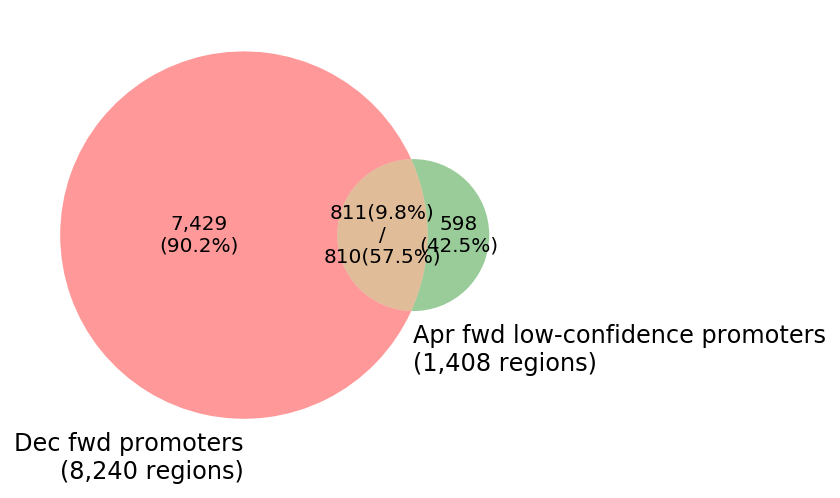

In [30]:
df_a_ = df_reglA.query('(annot_fwd == "coding_promoter") | (annot_fwd == "pseudogene_promoter")')[['chrom', 'start', 'end']]
df_b_ = df_reglB_lowconf_fwd.query('annot_lowconf == "True"')[['chrom', 'start', 'end']]

gv_f = yp.GenomicVenn2(
    BedTool.from_dataframe(df_a_),
    BedTool.from_dataframe(df_b_),
    label_a='Dec fwd promoters',
    label_b='Apr fwd low-confidence promoters',
)
gv_f.plot()

In [32]:
gv_f.df_b_only

,chrom,start,end
0,chrI,91353,91504
1,chrI,134218,134369
2,chrI,1041021,1041172
3,chrI,1199481,1199632
4,chrI,1834889,1835040
5,chrI,1943238,1943389
6,chrI,2401583,2401734
7,chrI,2632611,2632762
8,chrI,2636415,2636566
9,chrI,2773894,2774045


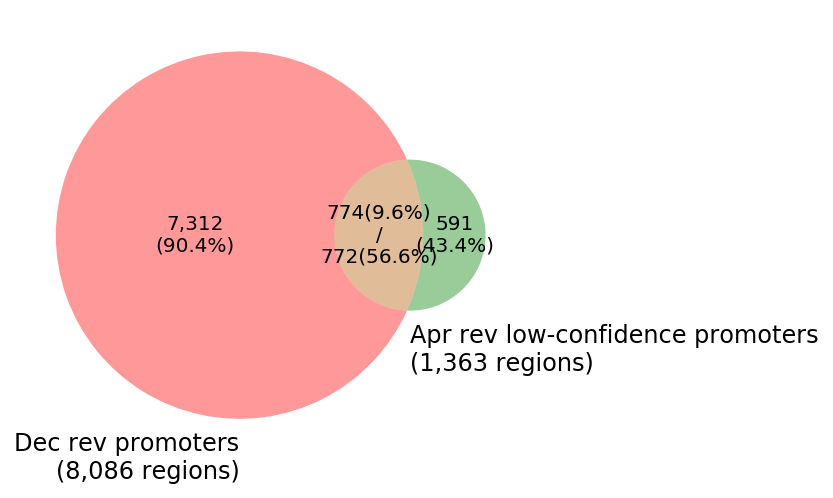

In [31]:
df_a_ = df_reglA.query('(annot_rev == "coding_promoter") | (annot_rev == "pseudogene_promoter")')[['chrom', 'start', 'end']]
df_b_ = df_reglB_lowconf_rev.query('annot_lowconf == "True"')[['chrom', 'start', 'end']]

gv_r = yp.GenomicVenn2(
    BedTool.from_dataframe(df_a_),
    BedTool.from_dataframe(df_b_),
    label_a='Dec rev promoters',
    label_b='Apr rev low-confidence promoters',
)
gv_r.plot()

In [74]:
fp_reglA = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_6Dec17.bed'
fp_reglB = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_20Apr18.bed'
fp_reglC = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_22Apr18.bed'
fp_reglD = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_23Apr18.bed'
fp_reglE = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_23A_Apr18.bed'
df_reglA = read_gffbed(fp_reglA)
df_reglB = read_gffbed(fp_reglB)
df_reglC = read_gffbed(fp_reglC)
df_reglD = read_gffbed(fp_reglD)
df_reglE = read_gffbed(fp_reglE)

/mnt/home1/ahringer/jj374/relmapping/scripts/yarp/yarp.py:400: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df_name = df_name.convert_objects(convert_numeric=True)


In [77]:
def overlap_(df_A, df_B):
    return sum((df_A['annot_fwd'] == "coding_promoter") & (df_B['annot_fwd'] == "coding_promoter")) + \
           sum((df_A['annot_rev'] == "coding_promoter") & (df_B['annot_rev'] == "coding_promoter"))

print('6Dec', overlap_(df_reglA, df_reglA), overlap_(df_reglA, df_reglB), overlap_(df_reglA, df_reglC), overlap_(df_reglA, df_reglD), overlap_(df_reglA, df_reglE), len(df_reglA.query('annot=="coding_promoter"')))
print('20Apr18', overlap_(df_reglB, df_reglA), overlap_(df_reglB, df_reglB), overlap_(df_reglB, df_reglC), overlap_(df_reglB, df_reglD), overlap_(df_reglB, df_reglE), len(df_reglB.query('annot=="coding_promoter"')))
print('22Apr18', overlap_(df_reglC, df_reglA), overlap_(df_reglC, df_reglB), overlap_(df_reglC, df_reglC), overlap_(df_reglC, df_reglD), overlap_(df_reglC, df_reglE), len(df_reglC.query('annot=="coding_promoter"')))
print('23Apr18', overlap_(df_reglD, df_reglA), overlap_(df_reglD, df_reglB), overlap_(df_reglD, df_reglC), overlap_(df_reglD, df_reglD), overlap_(df_reglD, df_reglE), len(df_reglD.query('annot=="coding_promoter"')))
print('23A_Apr18', overlap_(df_reglE, df_reglA), overlap_(df_reglE, df_reglB), overlap_(df_reglE, df_reglC), overlap_(df_reglE, df_reglD), overlap_(df_reglE, df_reglE), len(df_reglE.query('annot=="coding_promoter"')))

6Dec 15918 12061 12419 13080 12980 13817
20Apr18 12061 14340 14340 14340 14130 12729
22Apr18 12419 14340 15015 14939 14704 13302
23Apr18 13080 14340 14939 16096 15837 14088
23A_Apr18 12980 14130 14704 15837 15871 13884


In [72]:
df_reglD[(df_reglD['annot_fwd'] == 'coding_promoter') & \
         (df_reglE['annot_fwd'] != 'coding_promoter')][['chrom', 'start', 'end']].sample(10)

,chrom,start,end
12302,chrII,13506205,13506356
20915,chrIV,5186635,5186786
3996,chrI,9424649,9424800
16357,chrIII,7726813,7726964
24072,chrIV,12641486,12641637
16355,chrIII,7725682,7725833
20985,chrIV,5494624,5494775
15862,chrIII,6504199,6504350
21849,chrIV,7677295,7677446
6622,chrII,722848,722999


In [73]:
df_reglD[(df_reglD['annot_rev'] == 'coding_promoter') & \
         (df_reglE['annot_rev'] != 'coding_promoter')][['chrom', 'start', 'end']].sample(10)

,chrom,start,end
34479,chrX,2892760,2892911
17348,chrIII,9740739,9740890
18992,chrIV,122818,122969
21240,chrIV,6032531,6032682
5922,chrI,14048843,14048994
23412,chrIV,11215430,11215581
6233,chrI,14833834,14833985
38855,chrX,11103263,11103414
10864,chrII,10302116,10302267
36060,chrX,5727440,5727591


In [113]:
def diff_coding_promoter_lost(verA, verB):
    fp_reglA = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_%s.bed' % (verA,)
    fp_reglB = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_%s.bed' % (verB,)
    df_reglA = read_gffbed(fp_reglA)
    df_reglB = read_gffbed(fp_reglB)
    m_AtoB_fwd = (df_reglA['annot_fwd'] == 'coding_promoter') & (df_reglB['annot_fwd'] != 'coding_promoter')
    m_AtoB_rev = (df_reglA['annot_rev'] == 'coding_promoter') & (df_reglB['annot_rev'] != 'coding_promoter')
    #print(sum(m_AtoB_fwd), sum(m_AtoB_rev))

    fp_fwd = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_%s_to_%s_coding_promoter_lost_fwd.bed' % (verA, verB)
    fp_rev = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_%s_to_%s_coding_promoter_lost_rev.bed' % (verA, verB)
    df_reglA[m_AtoB_fwd][['chrom', 'start', 'end']].to_csv(fp_fwd, index=False, header=False, sep='\t')
    df_reglB[m_AtoB_rev][['chrom', 'start', 'end']].to_csv(fp_rev, index=False, header=False, sep='\t')
    !wc -l {fp_fwd}
    !wc -l {fp_rev}

def diff_coding_promoter_gained(verA, verB):
    fp_reglA = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_%s.bed' % (verA,)
    fp_reglB = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_%s.bed' % (verB,)
    df_reglA = read_gffbed(fp_reglA)
    df_reglB = read_gffbed(fp_reglB)
    m_AtoB_fwd = (df_reglA['annot_fwd'] != 'coding_promoter') & (df_reglB['annot_fwd'] == 'coding_promoter')
    m_AtoB_rev = (df_reglA['annot_rev'] != 'coding_promoter') & (df_reglB['annot_rev'] == 'coding_promoter')
    print(sum(m_AtoB_fwd), sum(m_AtoB_rev))

    fp_fwd = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_%s_to_%s_coding_promoter_gained_fwd.bed' % (verA, verB)
    fp_rev = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_%s_to_%s_coding_promoter_gained_rev.bed' % (verA, verB)
    df_reglA[m_AtoB_fwd][['chrom', 'start', 'end']].to_csv(fp_fwd, index=False, header=False, sep='\t')
    df_reglB[m_AtoB_rev][['chrom', 'start', 'end']].to_csv(fp_rev, index=False, header=False, sep='\t')
    !wc -l {fp_fwd}
    !wc -l {fp_rev}

#diff_coding_promoter_lost('23Apr18', '23A_Apr18')
#diff_coding_promoter_gained('23Apr18', '23A_Apr18')
#diff_coding_promoter_lost('Apr24a', 'Apr24b')
#diff_coding_promoter_gained('Apr24a', 'Apr24b')
diff_coding_promoter_lost('Apr24b', 'Apr24c')
diff_coding_promoter_gained('Apr24b', 'Apr24c')

/mnt/home1/ahringer/jj374/relmapping/scripts/yarp/yarp.py:400: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df_name = df_name.convert_objects(convert_numeric=True)


2 annot/S2_regulatory_annotation/S2_regulatory_annotation_Apr24b_to_Apr24c_coding_promoter_lost_fwd.bed
1 annot/S2_regulatory_annotation/S2_regulatory_annotation_Apr24b_to_Apr24c_coding_promoter_lost_rev.bed
163 185
163 annot/S2_regulatory_annotation/S2_regulatory_annotation_Apr24b_to_Apr24c_coding_promoter_gained_fwd.bed
185 annot/S2_regulatory_annotation/S2_regulatory_annotation_Apr24b_to_Apr24c_coding_promoter_gained_rev.bed


In [50]:
fp_ = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_6Dec17_to_22Apr18_lost_promoters_fwd.bed'
df_reglA[(df_reglA['annot_fwd'] == 'coding_promoter') & (df_reglC['annot_fwd'] != 'coding_promoter')]\
    [['chrom', 'start', 'end']].to_csv(fp_, index=False, header=False, sep='\t')
!wc -l {fp_}

fp_ = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_6Dec17_to_22Apr18_lost_promoters_rev.bed'
df_reglA[(df_reglA['annot_rev'] == 'coding_promoter') & (df_reglC['annot_rev'] != 'coding_promoter')]\
    [['chrom', 'start', 'end']].to_csv(fp_, index=False, header=False, sep='\t')
!wc -l {fp_}

fp_ = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_6Dec17_to_22Apr18_gained_promoters_fwd.bed'
df_reglA[(df_reglA['annot_fwd'] != 'coding_promoter') & (df_reglC['annot_fwd'] == 'coding_promoter')]\
    [['chrom', 'start', 'end']].to_csv(fp_, index=False, header=False, sep='\t')
!wc -l {fp_}

fp_ = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_6Dec17_to_22Apr18_gained_promoters_rev.bed'
df_reglA[(df_reglA['annot_rev'] != 'coding_promoter') & (df_reglC['annot_rev'] == 'coding_promoter')]\
    [['chrom', 'start', 'end']].to_csv(fp_, index=False, header=False, sep='\t')
!wc -l {fp_}

1793 annot/S2_regulatory_annotation/S2_regulatory_annotation_6Dec17_to_22Apr18_lost_promoters_fwd.bed
1706 annot/S2_regulatory_annotation/S2_regulatory_annotation_6Dec17_to_22Apr18_lost_promoters_rev.bed
1303 annot/S2_regulatory_annotation/S2_regulatory_annotation_6Dec17_to_22Apr18_gained_promoters_fwd.bed
1293 annot/S2_regulatory_annotation/S2_regulatory_annotation_6Dec17_to_22Apr18_gained_promoters_rev.bed


In [62]:
fp_ = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_6Dec17_to_23Apr18_lost_promoters_fwd.bed'
df_reglA[(df_reglA['annot_fwd'] == 'coding_promoter') & (df_reglC['annot_fwd'] != 'coding_promoter')]\
    [['chrom', 'start', 'end']].to_csv(fp_, index=False, header=False, sep='\t')
!wc -l {fp_}

fp_ = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_6Dec17_to_23Apr18_lost_promoters_rev.bed'
df_reglA[(df_reglA['annot_rev'] == 'coding_promoter') & (df_reglC['annot_rev'] != 'coding_promoter')]\
    [['chrom', 'start', 'end']].to_csv(fp_, index=False, header=False, sep='\t')
!wc -l {fp_}

fp_ = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_6Dec17_to_23Apr18_gained_promoters_fwd.bed'
df_reglA[(df_reglA['annot_fwd'] != 'coding_promoter') & (df_reglC['annot_fwd'] == 'coding_promoter')]\
    [['chrom', 'start', 'end']].to_csv(fp_, index=False, header=False, sep='\t')
!wc -l {fp_}

fp_ = 'annot/S2_regulatory_annotation/S2_regulatory_annotation_6Dec17_to_23Apr18_gained_promoters_rev.bed'
df_reglA[(df_reglA['annot_rev'] != 'coding_promoter') & (df_reglC['annot_rev'] == 'coding_promoter')]\
    [['chrom', 'start', 'end']].to_csv(fp_, index=False, header=False, sep='\t')
!wc -l {fp_}

1438 annot/S2_regulatory_annotation/S2_regulatory_annotation_6Dec17_to_23Apr18_lost_promoters_fwd.bed
1400 annot/S2_regulatory_annotation/S2_regulatory_annotation_6Dec17_to_23Apr18_lost_promoters_rev.bed
1508 annot/S2_regulatory_annotation/S2_regulatory_annotation_6Dec17_to_23Apr18_gained_promoters_fwd.bed
1508 annot/S2_regulatory_annotation/S2_regulatory_annotation_6Dec17_to_23Apr18_gained_promoters_rev.bed
